## APIs and Webscraping - Data Science Portfolio - Maximilian Koch

**Dataset**: Spotify songs, top 500 albums<br>
**Techniques applied**: API, webscraping, significance testing<br>

In this notebook, I will:
* Demonstrate the usage of the Spotify API
* Use BeautifulSoup to parse the top 500 albums of all time
* Get information about these albums using the Spotify API
* Analyse the average track duration over recent decades


### API access

In [3]:
#Get Spotify one hour access token
import requests
import base64

client_id = 'YOUR_CLIENT_ID'
client_secret = 'YOUR_CLIENT_SECRET'
#Spotify requires base64 encoding
auth_str = f"{client_id}:{client_secret}"
auth_bytes = auth_str.encode('utf-8')
auth_base64 = base64.b64encode(auth_bytes).decode('utf-8')

url = "https://accounts.spotify.com/api/token"
headers = {"Authorization": f"Basic {auth_base64}",
    "Content-Type": "application/x-www-form-urlencoded"}
data = {"grant_type": "client_credentials"}
response = requests.post(url, headers=headers, data=data)
response_data = response.json()
access_token = response_data['access_token']

print("Received acccess Token:", access_token)

search_url = "https://api.spotify.com/v1/search"
search_headers = {'Authorization': f'Bearer {access_token}'}

Received access Token: ...


### Most popular tracks from an artist

For demonstration purposes, this is how to get the most popular tracks from an artist!
1. The artist name is searched
2. The ID of the first result is extracted
3. That ID is used to find the top tracks

In [4]:
def most_popular_tracks(artist_name, n=5):
    global search_url, search_headers
    search_params = {'q': artist_name,
        'type': 'artist',
        'limit': 1} #only use first search result
    search_response = requests.get(search_url, headers=search_headers, params=search_params)
    #get artist ID
    if search_response.status_code == 200:
        search_results = search_response.json()
        artist_id = search_results['artists']['items'][0]['id']
    else:
        print(f"Error: {search_response.status_code}, {search_response.text}")

    #get most popular track
    top_tracks_url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks"
    top_tracks_response = requests.get(top_tracks_url, headers=search_headers)

    if top_tracks_response.status_code == 200:
        #already sorted by most popular, thus first n tracks
        top_tracks = top_tracks_response.json()['tracks'][:n]
        track_list = []
        for track in top_tracks:
            track_list.append((track['name'],track['popularity']))
        return track_list
    else:
        print(f"Error: {top_tracks_response.status_code}, {top_tracks_response.text}")

track_name, popularity = most_popular_tracks('Rick Astley',1)[0]
print(f"The probability that Rick Astley is {track_name}: {popularity}%!")

#Get top 5 Michael Jackson songs, hehe
print("\nThe top five Michael Jackson songs are:")
for track in most_popular_tracks('Michael Jackson',5):
    print(f"{track[0]} has a popularity of {track[1]}")


The probability that Rick Astley is Never Gonna Give You Up: 81%!

The top five Michael Jackson songs are:
Billie Jean has a popularity of 84
Beat It has a popularity of 81
Smooth Criminal - 2012 Remaster has a popularity of 77
Rock with You - Single Version has a popularity of 80
Chicago has a popularity of 80


### Scraping albums

Using Beautiful Soup to scrape the top 500 greatest albums of all time (according to Rolling Stone Magazine).
Clearly, this data would also be available somewhere in csv format, but it is suitable for demonstration:

In [3]:
from bs4 import BeautifulSoup

In [4]:
text = requests.get('https://rocknyc.live/the-gigantic-list-published-by-rolling-stone-the-500-greatest-albums-of-all-time.html').text
soup = BeautifulSoup(text, 'html.parser')

albums_data = []

#the entire list is within several html paragraphs, each entry is separated with the pipe symbol
for paragraph in soup.find_all('p'):
    lines = paragraph.text.split('\n')
    for line in lines:
        parts = line.split('|')
        if len(parts) == 4:
            rank = int(parts[0].strip())
            artist = parts[1].strip()
            album = parts[2].strip()
            year = int(parts[3].strip()[:4])
            albums_data.append((rank,artist,album,year))
print("The top ten albums of all time are:")
for i in albums_data[:10]:
    rank,artist,album,year = i
    print(f"{rank}: {album} by {artist}, {year}")


The top ten albums of all time are:
1: What’s Going On by Marvin Gaye, 1971
2: Pet Sounds by The Beach Boys, 1966
3: Blue by Joni Mitchell, 1971
4: Songs in the Key of Life by Stevie Wonder, 1976
5: Abbey Road by The Beatles, 1969
6: Nevermind by Nirvana, 1991
7: Rumours by Fleetwood Mac, 1977
8: Purple Rain by Prince and the Revolution, 1984
9: Blood on the Tracks by Bob Dylan, 1975
10: The Miseducation of Lauryn Hill by Lauryn Hill, 1998


### Album info

Combining the Spotify API with the top 500 albums list, to get more information about these albums!

In [5]:
def get_album_info(search_query):
    global search_url, search_headers
    #search for album to get album ID
    params = {'q': search_query,
        'type': 'album',
        'limit': 1 } #only use first search result
    search_response = requests.get(search_url, headers=search_headers, params=params)
    search_data = search_response.json()

    if not search_data['albums']['items']:
        return None,""

    album = search_data['albums']['items'][0]
    album_id = album['id']
    album_name = album['name']

    #get details using album ID
    album_url = f'https://api.spotify.com/v1/albums/{album_id}'
    album_response = requests.get(album_url, headers=search_headers)
    album_data = album_response.json()
    #get duration details
    total_tracks = album_data['total_tracks']
    total_duration_ms = sum(track['duration_ms'] for track in album_data['tracks']['items'])
    total_duration_minutes = total_duration_ms / 1000 / 60
    average_duration_minutes = total_duration_minutes / total_tracks if total_tracks > 0 else 0
    
    return {
        'album_name': album_name,
        'total_tracks': total_tracks,
        'total_duration': round(total_duration_minutes,2),
        'average_duration': round(average_duration_minutes,2)
    }, None

#Looking at the 79th best album in the world:
n=79
rank,artist,album,year=albums_data[n-1]
print(f'The top {n} album in the world is {album} by {artist} from {year}.')
album_info, error= get_album_info(artist+album)
print(f"{album_info['album_name']} has {album_info['total_tracks']} tracks with a total duration of {album_info['total_duration']}mins and average {album_info['average_duration']}mins per track!")


The top 79 album in the world is Blonde by Frank Ocean from 2016.
Blonde has 17 tracks with a total duration of 60.29mins and average 3.55mins per track!


Now, getting the info for all top 500 albums using the spotify api

In [6]:
import pandas as pd
from tqdm import tqdm

df = pd.DataFrame(albums_data,columns=['Rank', 'Artist', 'Album', 'Year'])

df['Number of Tracks'] = None
df['Total Duration'] = None
df['Average Track Duration'] = None

#add album data to dataframe
#usually took me about 2.5mins to run. might take longer depending on time/WiFi
for index, row in tqdm(df.iterrows()):
    
    search_query = f"{row['Artist']} {row['Album']}"
    
    # Get album information using the combined artist + album name
    album_info, error = get_album_info(search_query)
    
    if album_info:
        # Update the DataFrame with the results
        df.at[index, 'Number of Tracks'] = album_info['total_tracks']
        df.at[index, 'Total Duration'] = album_info['total_duration']
        df.at[index, 'Average Track Duration'] = album_info['average_duration']
    else:
        #In case of error 429 (overload), include a time.sleep(0.5) after each iteration, wait some hours or create a new key set
        print(f"Error for '{search_query}': {error}")

500it [03:30,  2.38it/s]


In [7]:
df

,Rank,Artist,Album,Year,Number of Tracks,Total Duration,Average Track Duration
0,1,Marvin Gaye,What’s Going On,1971,9,35.54,3.95
1,2,The Beach Boys,Pet Sounds,1966,13,37.36,2.87
2,3,Joni Mitchell,Blue,1971,10,36.08,3.61
3,4,Stevie Wonder,Songs in the Key of Life,1976,21,105.03,5.0
4,5,The Beatles,Abbey Road,1969,17,47.5,2.79
...,...,...,...,...,...,...,...
495,496,Shakira,Dónde Están los Ladrones,1998,11,41.23,3.75
496,497,Various Artists,The Indestructible Beat of Soweto,1985,12,45.85,3.82
497,498,Suicide,Suicide,1977,9,18.57,2.06
498,499,Rufus & Chaka Khan,Ask Rufus,1977,9,37.76,4.2


### Analysing track duration

Since the data has been collected now, out of curiosity I wanted to check a widely-spread hypothesis that the duration of songs is decreasing in recent years. E.g., an article here: https://ucladatares.medium.com/spotify-trends-analysis-129c8a31cf04

Is that also the case for the 'best' rated music?

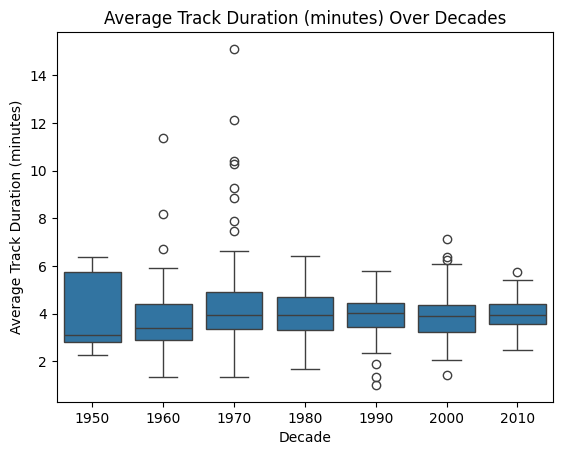

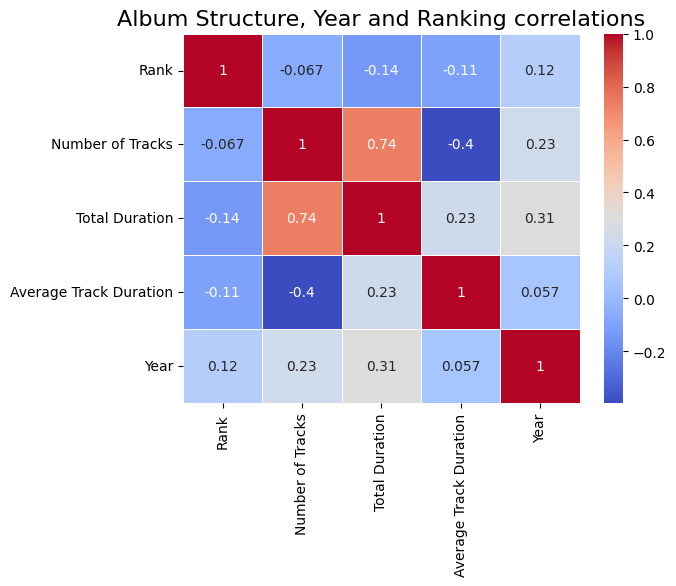

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df['Decade'] = (df['Year'] // 10) * 10
sns.boxplot(x='Decade', y='Average Track Duration', data=df)
plt.title('Average Track Duration (minutes) Over Decades')
plt.xlabel('Decade')
plt.ylabel('Average Track Duration (minutes)')
plt.show()

corr = df[['Rank', 'Number of Tracks', 'Total Duration', 'Average Track Duration', 'Year']].corr('spearman')

sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Album Structure, Year and Ranking correlations', fontsize=16)
plt.show()


From the first plot it is hard to tell the significance, thus I am applying a Mann-Whitney U test to measure:

Is there a significant change in average track duration for songs before 2000 and after 2000?

In [9]:
from scipy import stats
df_1 = df[df['Year']<2000]
df_2 = df[df['Year']>=2000]
duration_1 = df_1['Average Track Duration'].values.astype(float)
duration_2 = df_2['Average Track Duration'].values.astype(float)

#--> Variance not similar
print(duration_1.var(),duration_2.var())

#--> not normally distributed
print(stats.shapiro(duration_1))
print(stats.shapiro(duration_2))

#--> time for Mann-Whitney U!
print(stats.mannwhitneyu(duration_1,duration_2,alternative='greater'))

2.0057315876683237 0.9065387777176849
ShapiroResult(statistic=np.float64(0.8240009036296909), pvalue=np.float64(5.718389970356855e-21))
ShapiroResult(statistic=np.float64(0.9727816954658484), pvalue=np.float64(0.06604138380990572))
MannwhitneyuResult(statistic=np.float64(17677.0), pvalue=np.float64(0.5409936398010747))


Change in track duration does not seem to be significant for the top 500 Rolling stone albums!
Although methodologically, album duration is not the most logical way to determine this due to plenty of outliers etc., but since I had collected the data anyway, I wanted to check.